# Utils

### Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import glob
import nibabel as nib
import umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
import hdbscan

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm

In [2]:
import warnings

# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Paths and folders

In [3]:
# FC maps mean
dir_FCmaps = '/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps'
dir_FCmaps3D_processed = '/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps_processed'
dir_data_utils = "/Users/emmatosato/Documents/PhD/ANM_Verona/data_utils/"
gm_mask_path = '/Users/emmatosato/Documents/PhD/ANM_Verona/data_utils/GM_mask.nii'
harvard_oxford_mask_path = '/Users/emmatosato/Documents/PhD/ANM_Verona/data_utils/mask_GM.nii'
atrophy_dataset_matches = '/Users/emmatosato/Documents/PhD/ANM_Verona/data_utils/metadata/atrophy_matched.xlsx'
labels_csv = '/Users/emmatosato/Documents/PhD/ANM_Verona/data_utils'
save_path = "/Users/emmatosato/Documents/PhD/ANM_Verona/output_images"

In [4]:
# Create output directory if it doesn't exist
os.makedirs(dir_FCmaps3D_processed, exist_ok=True)

# Data

Function for listing the data in nii.gz format and extract the subjects identifiers + printing some infos

In [5]:
def listData_saveID(dir):
    # All nii.gz files in the directory
    files_path = sorted(glob.glob(os.path.join(dir, '*gz')))

    # Extract Subject IDs from filenames
    subject_id = [os.path.basename(f).replace('.FDC.nii.gz', '') for f in files_path]

    print("Check length:")
    print("Files: ", len(files_path))
    print("Subject: ", len(subject_id))

    return files_path, subject_id

In [6]:
files, sub_id = listData_saveID(dir_FCmaps)

Check length:
Files:  177
Subject:  177


In [7]:
files[:5]

['/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/002_S_4654.FDC.nii.gz',
 '/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/002_S_6695.FDC.nii.gz',
 '/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/003_S_6264.FDC.nii.gz',
 '/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/003_S_6268.FDC.nii.gz',
 '/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/003_S_6432.FDC.nii.gz']

One file example

In [8]:
# Load an image
path_temp = os.path.join(dir_FCmaps, '1_S_5005.FDC.nii.gz')
img = nib.load(path_temp)

# --- Separate the data and affine ---
temp_img = img.get_fdata()      # 3D volume data
temp_affine = img.affine        # 4x4 affine matrix

In [9]:
temp_img.shape

(91, 109, 91)

In [10]:
temp_affine.shape

(4, 4)

## Raw data

#### Load data

In [11]:
maps_FDC=[]
for x in range(len(files)):
    print(files[x])
    d=nib.load(files[x]).get_fdata().flatten()
    maps_FDC.append(d)

# Stores subjects as rows and voxels as columns + subjects id
df=pd.DataFrame(maps_FDC)

/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/002_S_4654.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/002_S_6695.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/003_S_6264.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/003_S_6268.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/003_S_6432.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/003_S_6479.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/003_S_6606.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/006_S_6252.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/006_S_6682.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/007_S_6341.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/011_S_4893.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/011_S_6303.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/012_S_4188.FDC.nii.gz

#### EDA

In [12]:
print(f"Shape of the dataframe: {df.shape}")

Shape of the dataframe: (177, 902629)


In [13]:
# --- Global Statistics ---
all_voxels = df.values.flatten()
all_voxels = all_voxels[~np.isnan(all_voxels)]

# --- Descriptive statistics ---
stats_summary = {
    "Min": np.min(all_voxels),
    "Max": np.max(all_voxels),
    "Mean": np.mean(all_voxels),
    "Std": np.std(all_voxels),
    "1st Percentile": np.percentile(all_voxels, 1),
    "25th Percentile": np.percentile(all_voxels, 25),
    "Median (50th)": np.percentile(all_voxels, 50),
    "75th Percentile": np.percentile(all_voxels, 75),
    "99th Percentile": np.percentile(all_voxels, 99),
}

df_stats = pd.DataFrame.from_dict(stats_summary, orient='index', columns=['Value'])
print(df_stats)

                    Value
Min             -0.549580
Max              1.618776
Mean             0.021865
Std              0.056470
1st Percentile  -0.013114
25th Percentile  0.000000
Median (50th)    0.000000
75th Percentile  0.008684
99th Percentile  0.267919


## Metadata

Dataset containing:
- ID of the subject
- The diagnosis (Group)
- Sex
- Age
- Education

The regressors:
- CDR_SB: disease gravity with a larger range
- CDR: same but smaller range

In [14]:
# Load the metadata and align to FC map order
df_meta = pd.read_excel(atrophy_dataset_matches, sheet_name='dataset')
df_meta['Age'] = df_meta['Age'].round(1)

In [15]:
df_meta.head(5)

,ID,Group,Sex,Age,Education,CDR_SB,CDR
0,1_S_5000,CBS,M,70.0,16,5.0,1.0
1,1_S_5001,CBS,F,65.0,16,15.0,3.0
2,1_S_5003,PSP,F,86.0,18,1.0,0.5
3,1_S_5004,PSP,F,67.0,14,1.5,0.5
4,1_S_5005,PSP,F,67.0,20,0.0,0.0


#### EDA on Labels

In [16]:
print("CONTROLS")
print("Excel: ",df_meta.shape)

CONTROLS
Excel:  (177, 7)


In [17]:
# General info
print(df_meta.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         177 non-null    object 
 1   Group      177 non-null    object 
 2   Sex        177 non-null    object 
 3   Age        177 non-null    float64
 4   Education  177 non-null    int64  
 5   CDR_SB     172 non-null    float64
 6   CDR        172 non-null    float64
dtypes: float64(3), int64(1), object(3)
memory usage: 9.8+ KB
None


In [18]:
# Missing values
print("\nMissing values for column:")
print(df_meta.isna().sum())


Missing values for column:
ID           0
Group        0
Sex          0
Age          0
Education    0
CDR_SB       5
CDR          5
dtype: int64


Unique values WITH NaN

In [19]:
print("\nUnique Values:")
print("Group:", sorted(df_meta['Group'].unique()))
print("CDR:", np.sort(df_meta['CDR'].unique()))
print("CDR_SB:", np.sort(df_meta['CDR_SB'].unique()))


Unique Values:
Group: ['ADNI', 'CBS', 'PSP']
CDR: [0.  0.5 1.  2.  3.  nan]
CDR_SB: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   9.   9.5 10.  11.  12.  13.5 14.  15.  16.  18.   nan]


Unique values WITHOUT NaN

In [20]:
cdr_no_nan = df_meta['CDR'].dropna()
cdr_sb_no_nan = df_meta['CDR_SB'].dropna()

In [21]:
print("\nUnique Values:")
print("CDR:", np.sort(cdr_no_nan.unique()))
print("CDR_SB:", np.sort(cdr_sb_no_nan.unique()))


Unique Values:
CDR: [0.  0.5 1.  2.  3. ]
CDR_SB: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   9.   9.5 10.  11.  12.  13.5 14.  15.  16.  18. ]


In [22]:
print(df_meta.select_dtypes(include='number').describe().round(1))

         Age  Education  CDR_SB    CDR
count  177.0      177.0   172.0  172.0
mean    70.9       15.9     4.1    0.8
std      8.3        3.5     3.5    0.6
min     53.0        2.0     0.0    0.0
25%     64.0       14.0     1.5    0.5
50%     71.2       16.0     3.5    0.5
75%     76.0       18.0     6.0    1.0
max     93.8       27.0    18.0    3.0


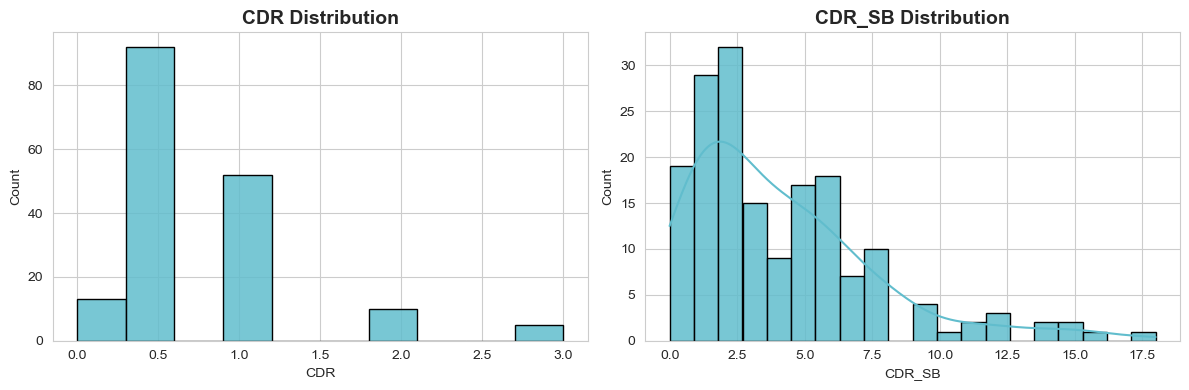

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(cdr_no_nan, bins=10, ax=axes[0], color='#61bdcd', edgecolor='black', alpha=0.85)
axes[0].set_title("CDR Distribution", fontsize=14, weight='bold')

sns.histplot(cdr_sb_no_nan, bins=20, ax=axes[1], color='#61bdcd', edgecolor='black', alpha=0.85, kde=True)
axes[1].set_title("CDR_SB Distribution", fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

# UMAP

## Data

### Load data



Store each subject’s data in the dataframe of flatten data created before

In [24]:
# Insert subjects id
df.insert(0, 'ID', sub_id)

In [25]:
print("\n", df.shape, "\n")
df.iloc[:5, :5]


 (177, 902630) 



,ID,0,1,2,3
0,002_S_4654,0.0,0.0,0.0,0.0
1,002_S_6695,0.0,0.0,0.0,0.0
2,003_S_6264,0.0,0.0,0.0,0.0
3,003_S_6268,0.0,0.0,0.0,0.0
4,003_S_6432,0.0,0.0,0.0,0.0


The order of the subject must be the same of the dataframe of the FC maps

In [26]:
df_meta = df_meta.set_index('ID').loc[df['ID']].reset_index()

assert all(df['ID'] == df_meta['ID']), "Mismatch tra ID di df e df_meta_ordered"
print("Gli ID ora sono perfettamente allineati")

Gli ID ora sono perfettamente allineati


### Preprocessing

#### Removing NaN subjects

In [27]:
print("Recall rows with missing CDR_SB:", df_meta['CDR_SB'].isna().sum())
subjects_nan = df_meta[df_meta['CDR_SB'].isna()]['ID'].tolist()
print("Subject with missing CDR_SB:", subjects_nan)

Recall rows with missing CDR_SB: 5
Subject with missing CDR_SB: ['1_S_5052', '1_S_5096', '1_S_5097', '1_S_5101', '4_S_5008']


In [28]:
df = df[~df['ID'].isin(subjects_nan)].reset_index(drop=True)
print("New dimension of df:", df.shape)

New dimension of df: (172, 902630)


#### Thresholding

Set a threshold for values below 0.1 and 0.2 for defining correlation

In [29]:
def apply_threshold(dataframe, threshold):
    df_thr = dataframe.copy()
    df_thr.iloc[:, 1:] = df_thr.iloc[:, 1:].mask(df_thr.iloc[:, 1:] < threshold, 0)
    return df_thr

In [30]:
df_thr_01 = apply_threshold(df, threshold=0.1)

In [31]:
df_thr_02 = apply_threshold(df, threshold=0.2)

#### GM Mask

- Binary mask of grey matter using the Harvard-Oxford Atlas

- Keeping the Gray Matter voxels

In [32]:
def apply_mask(df_thr, mask_path):
    # Load and flatten GM mask
    mask = nib.load(mask_path).get_fdata().flatten()
    assert mask.shape[0] == df_thr.shape[1] - 1, "Mask and data length mismatch"

    # Mask
    voxel_data = df_thr.iloc[:, 1:]
    voxel_data_masked = voxel_data.loc[:, mask != 0]

    # Return the masked dataframe
    df_masked = pd.concat([df_thr[['ID']], voxel_data_masked], axis=1)
    df_masked.columns = ['ID'] + list(range(voxel_data_masked.shape[1]))
    return df_masked

In [33]:
# GM masking
# 0.1 threshold
df_thr01_gm_masked = apply_mask(df_thr_01, gm_mask_path)

# 0.2 threshold
df_thr02_gm_masked = apply_mask(df_thr_02, gm_mask_path)

# Without threshold
df_gm_masked = apply_mask(df, gm_mask_path)

In [34]:
# Harvard masking
# 0.1 threshold
df_thr01_har_masked = apply_mask(df_thr_01, harvard_oxford_mask_path)

# 0.2 threshold
df_thr02_har_masked = apply_mask(df_thr_02, harvard_oxford_mask_path)

# Without
df_har_masked = apply_mask(df, harvard_oxford_mask_path)

### Analysis

In [35]:
print("Dimensions of dataframes after gm masking with 2 different thresholds:")
print("0.1 threshold", df_thr01_gm_masked.shape)
print("0.2 threshold", df_thr02_gm_masked.shape)

print("\nDimensions of dataframes after harvard masking with 2 different thresholds:")
print("0.1 threshold", df_thr01_har_masked.shape)
print("0.2 threshold", df_thr02_har_masked.shape)

print("\nDimensions of dataframes after gm masking and harvard masking without thresholding:")
print("GM Mask", df_gm_masked.shape)
print("Harvard Mask", df_har_masked.shape)

Dimensions of dataframes after gm masking with 2 different thresholds:
0.1 threshold (172, 161818)
0.2 threshold (172, 161818)

Dimensions of dataframes after harvard masking with 2 different thresholds:
0.1 threshold (172, 55005)
0.2 threshold (172, 55005)

Dimensions of dataframes after gm masking and harvard masking without thresholding:
GM Mask (172, 161818)
Harvard Mask (172, 55005)


In [36]:
# Funzione migliorata
def summarize_voxel_data(df_masked, threshold=None):
    summary = {}
    summary['Shape'] = df_masked.shape

    if threshold:
        has_low = ((df_masked.iloc[:, 1:] > 0) & (df_masked.iloc[:, 1:] < threshold)).any().any()
        summary['Valori tra 0 e threshold'] = has_low
    else:
        summary['Valori tra 0 e threshold'] = 'N/A'

    zero_rows = (df_masked.iloc[:, 1:] == 0).all(axis=1).sum()
    summary['Zero maps'] = f"{zero_rows} su {df_masked.shape[0]}"

    voxel_data = df_masked.iloc[:, 1:].values
    nonzero_voxels = voxel_data[voxel_data != 0]

    summary['All Min'] = voxel_data.min()
    summary['All Max'] = voxel_data.max()
    summary['All Mean'] = voxel_data.mean()
    summary['All Std'] = voxel_data.std()

    summary['Nonzero Min'] = nonzero_voxels.min()
    summary['Nonzero Max'] = nonzero_voxels.max()
    summary['Nonzero Mean'] = nonzero_voxels.mean()
    summary['Nonzero Std'] = nonzero_voxels.std()

    return summary

In [37]:
# Dataset
dataframes = {
    "thr_01_gm": (df_thr01_gm_masked, 0.1),
    "thr_02_gm": (df_thr02_gm_masked, 0.2),
    "thr_01_har": (df_thr01_har_masked, 0.1),
    "thr_02_har": (df_thr02_har_masked, 0.2),
    "gm_no_thr": (df_gm_masked, None),
    "har_no_thr": (df_har_masked, None)
}

# Functions
results = []

for name, (dfm, thr) in dataframes.items():
    summary = summarize_voxel_data(dfm, threshold=thr)
    summary['Dataset'] = name
    results.append(summary)

# Summary
df_summary = pd.DataFrame(results).set_index('Dataset')

pd.options.display.float_format = '{:.4f}'.format

In [38]:
print("Summary of voxel data:")
display(df_summary)

Summary of voxel data:


,Shape,Valori tra 0 e threshold,Zero maps,All Min,All Max,All Mean,All Std,Nonzero Min,Nonzero Max,Nonzero Mean,Nonzero Std
Dataset,,,,,,,,,,,
thr_01_gm,"(172, 161818)",False,0 su 172,0.0000,1.6188,0.0728,0.1016,0.1000,1.6188,0.1824,0.0765
thr_02_gm,"(172, 161818)",False,0 su 172,0.0000,1.6188,0.0337,0.0935,0.2000,1.6188,0.2745,0.0709
thr_01_har,"(172, 55005)",False,0 su 172,0.0000,1.6188,0.0838,0.1064,0.1000,1.6188,0.1862,0.0779
thr_02_har,"(172, 55005)",False,9 su 172,0.0000,1.6188,0.0405,0.1013,0.2000,1.6188,0.2750,0.0721
gm_no_thr,"(172, 161818)",N/A,0 su 172,-0.2879,1.6188,0.0992,0.0866,-0.2879,1.6188,0.0992,0.0866
har_no_thr,"(172, 55005)",N/A,0 su 172,-0.1555,1.6188,0.1078,0.0912,-0.1555,1.6188,0.1078,0.0912


## Unsupervised Clustering

### Input data

For the further analysis we will remove the ID labels columns, but the order is mantained.

Possible dataset:
- `df_thr01_gm_masked`
- `df_thr02_gm_masked`
- `df_thr01_har_masked`
- `df_thr02_har_masked`
- `df_gm_masked`
- `df_har_masked`

Here we go with one example

In [64]:
def x_features_return(df_voxel, df_labels):
    # Meta columns
    meta_columns = list(df_labels.columns)

    # Merge based on subject ID
    dataframe_merge = pd.merge(df_voxel, df_labels, on='ID', how='left', validate='one_to_one')

    # Reorder columns: metadata first, then voxel features
    ordered_cols = meta_columns + [col for col in dataframe_merge.columns if col not in meta_columns]
    dataframe_merge = dataframe_merge[ordered_cols]

    # Sanity check to ensure row alignment
    assert (dataframe_merge['ID'].values == df_voxel['ID'].values).all(), "Row order mismatch after merge"

    # Extract features only (drop metadata)
    x = dataframe_merge.drop(columns=meta_columns)

    return dataframe_merge, x

In [65]:
df_merged, X = x_features_return(df_gm_masked, df_meta)

In [66]:
X.shape

(172, 161817)

### Dimensionality reduction and clustering

UMAP is not changing the order of the rows so each row correspond to the previous subject in the not reduced dataset.

In [69]:
def run_umap(x_input, plot_flag =True):
   # Parameters
    reducer = umap.UMAP(n_neighbors=15, n_components=2, metric='euclidean', n_epochs=1000, learning_rate=1.0, init='spectral', min_dist=0.1, spread=1.0, low_memory=False, set_op_mix_ratio=1.0, local_connectivity=1, repulsion_strength=1.0, negative_sample_rate=5, transform_queue_size=4.0, a=None, b=None, random_state=42, metric_kwds=None, angular_rp_forest=False, target_n_neighbors=-1, transform_seed=42, verbose=False, unique=False)

    # Reduce dimensionality
    x_umap = reducer.fit_transform(x_input)

    # Plot
    if plot_flag:
        plt.figure(figsize=(6, 4))
        plt.scatter(x_umap[:, 0], x_umap[:, 1], s=10, alpha=0.6)
        plt.title("UMAP Embedding")
        plt.xlabel("UMAP 1")
        plt.ylabel("UMAP 2")
        plt.grid(True)
        plt.show()

    return x_umap

In [ ]:
X_umap = run_umap(X, plot_flag=True)

In [ ]:
threshold_y = 15

# Maks
top_mask = X_umap[:, 1] > threshold_y
bottom_mask = X_umap[:, 1] <= threshold_y

# --- Top ---
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[top_mask, 0], X_umap[top_mask, 1], s=40, alpha=0.8)
plt.title("UMAP - Upper Cluster(s)", fontsize=14, weight='bold')
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# --- Bottom ---
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[bottom_mask, 0], X_umap[bottom_mask, 1], s=40, alpha=0.8)
plt.title("UMAP - Lower Cluster", fontsize=14, weight='bold')
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [133]:
# HDBSCAN
cluster_hdb = hdbscan.HDBSCAN(min_cluster_size=5)
labels_hdb = cluster_hdb.fit_predict(X_umap)

# DBSCAN
clusterer_db = DBSCAN(eps=0.5, min_samples=5)
labels_db = clusterer_db.fit_predict(X_umap)

# K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
labels_km = kmeans.fit_predict(X_umap)

# GMM
gmm = GaussianMixture(n_components=3, random_state=42)
labels_gmm = gmm.fit_predict(X_umap)

# Dataframe for collecting data
labeling_umap = pd.DataFrame({
    'labels_hdb': labels_hdb,  # HDBSCAN clusters
    'labels_db': labels_db,    # DBSCAN clusters
    'labels_km': labels_km,    # K-Means clusters
    'labels_gmm': labels_gmm,  # GMM clusters
    'X1': X_umap[:, 0],        # UMAP component 1
    'X2': X_umap[:, 1],        # UMAP component 2
    'group': df_merged['Group'],        # Diagnosis
    'subject_id': df_merged['ID']       # Identifiers
})

### Plotting

In [134]:
def plot_clusters_vs_groups(x_umap, labels_dictionary, group_column, figsize=(16, 24), margin=5):
    n = len(labels_dict)
    n_cols = 2
    n_rows = n

    x_min, x_max = x_umap[:, 0].min() - margin, x_umap[:, 0].max() + margin
    y_min, y_max = x_umap[:, 1].min() - margin, x_umap[:, 1].max() + margin

    # Figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

    # Loop over each clustering model
    for i, (title, labels) in enumerate(labels_dictionary.items()):
        ax_left = axes[i, 0]
        ax_right = axes[i, 1]

        # DF for for plotting
        plot_df = pd.DataFrame({
            'X1': x_umap[:, 0],
            'X2': x_umap[:, 1],
            'cluster': labels,
            'group': group_column
        })

        # Clustering
        sns.scatterplot(data=plot_df, x='X1', y='X2', hue='cluster', palette='Set1', s=50, ax=ax_left, legend='full')
        ax_left.set_title(f'{title} - Clustering')
        ax_left.set_xlim(x_min, x_max)
        ax_left.set_ylim(y_min, y_max)
        ax_left.set_xlabel("UMAP 1")
        ax_left.set_ylabel("UMAP 2")

        # Group labeling
        sns.scatterplot(data=plot_df, x='X1', y='X2', hue='group', palette='Set2', s=50, ax=ax_right, legend='full')
        ax_right.set_title(f'{title} - Group Labeling')
        ax_right.set_xlim(x_min, x_max)
        ax_right.set_ylim(y_min, y_max)
        ax_right.set_xlabel("UMAP 1")
        ax_right.set_ylabel("UMAP 2")

    plt.tight_layout()
    plt.show()

In [ ]:
# Dictionary of clustering results
labels_dict = {
    "HDBSCAN": labeling_umap['labels_hdb'],
    "DBSCAN": labeling_umap['labels_db'],
    "K-Means": labeling_umap['labels_km'],
    "GMM": labeling_umap['labels_gmm']
}

plot_clusters_vs_groups(X_umap, labels_dict, labeling_umap['group'])

### Run all dataframes

In [59]:
import sys
sys.path.append("/Users/emmatosato/Documents/PhD/ANM_Verona/src")

import importlib
import umap_clustering
importlib.reload(umap_clustering)

from umap_clustering import main

save_path = "/Users/emmatosato/Documents/PhD/ANM_Verona/output_images/umap_cluster"

In [ ]:
labeling, x_umap = main(df_gm_masked,df_meta, save_path, "umap_gm_mask", "clustering_gm_mask", plot_umap_flag=False, plot_cluster_flag=True)
labeling, x_umap = main(df_thr01_gm_masked, df_meta, save_path, "umap_gm_01_mask", "clustering_gm_01_mask", plot_umap_flag=False, plot_cluster_flag=True)
labeling, x_umap = main(df_thr02_gm_masked, df_meta, save_path, "umap_gm_02_mask", "clustering_gm_02_mask", plot_umap_flag=False, plot_cluster_flag=True)
labeling, x_umap = main(df_thr01_har_masked, df_meta, save_path, "umap_har_01_mask", "clustering_har_01_mask", plot_umap_flag=False, plot_cluster_flag=True)
labeling, x_umap = main(df_thr02_har_masked, df_meta, save_path, "umap_har_02_mask", "clustering_har_02_mask", plot_umap_flag=False, plot_cluster_flag=True)
labeling, x_umap = main(df_har_masked, df_meta, save_path, "umap_har_mask", "clustering_har_mask", plot_umap_flag=False, plot_cluster_flag=True)

## Linear Regression

Input and target definition

In [70]:
# Features
df_merged, X = x_features_return(df_gm_masked, df_meta)

# Target variable
y = df_merged['CDR_SB']
y_log = np.log1p(y)

Reduction

In [71]:
X_umap = run_umap(X, plot_flag=False)

Fit  regressions model

In [72]:
def fit_ols_model(input_data, target):
    # Add a constant to the features
    input_constants = sm.add_constant(input_data)

    # Fit the OLS model
    model_ols = sm.OLS(y, input_constants).fit()

    # Predictions and residuals
    predictions = model_ols.predict(input_constants)
    residuals_ols = target - predictions

    return model_ols, predictions, residuals_ols

In [73]:
def plot_ols_diagnostics(target, predictions, residuals_ols, title):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot 1: True vs Predicted
    sns.scatterplot(x=target, y=predictions, ax=axes[0], color='#61bdcd', edgecolor='black', alpha=0.8, s=50)
    axes[0].plot([target.min(), target.max()], [target.min(), target.max()], '--', color='gray')
    axes[0].set_title("True vs Predicted", fontsize=14, weight='bold')
    axes[0].set_xlabel("True CDR_SB", fontsize=12, weight='bold')
    axes[0].set_ylabel("Predicted CDR_SB", fontsize=12, weight='bold')
    axes[0].grid(True, linestyle='--', alpha=0.6)

    # Plot 2: Residuals vs Predicted
    sns.scatterplot(x=predictions, y=residuals_ols, ax=axes[1], color='#61bdcd', edgecolor='black', alpha=0.8, s=50)
    axes[1].axhline(0, linestyle='--', color='gray')
    axes[1].set_title("Residuals vs Fitted", fontsize=14, weight='bold')
    axes[1].set_xlabel("Predicted CDR_SB", fontsize=12, weight='bold')
    axes[1].set_ylabel("Residuals", fontsize=12, weight='bold')
    axes[1].grid(True, linestyle='--', alpha=0.6)

    # Titolo globale sopra i due plot
    fig.suptitle(title,fontsize=16, weight='bold', y=1.05)
    plt.tight_layout()
    plt.show()

Without logistic normalization  of the target

In [74]:
model, y_pred, residuals = fit_ols_model(X_umap, y)
print(model.summary(),"\n")

                            OLS Regression Results                            
Dep. Variable:                 CDR_SB   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     6.361
Date:                Wed, 07 May 2025   Prob (F-statistic):            0.00217
Time:                        18:14:35   Log-Likelihood:                -451.89
No. Observations:                 172   AIC:                             909.8
Df Residuals:                     169   BIC:                             919.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0175      0.481      8.351      0.0

With logistic normalization  of the target

In [83]:
model_log, y_pred_log, residuals_log = fit_ols_model(X_umap, y_log)
#print(model.summary(),"\n")

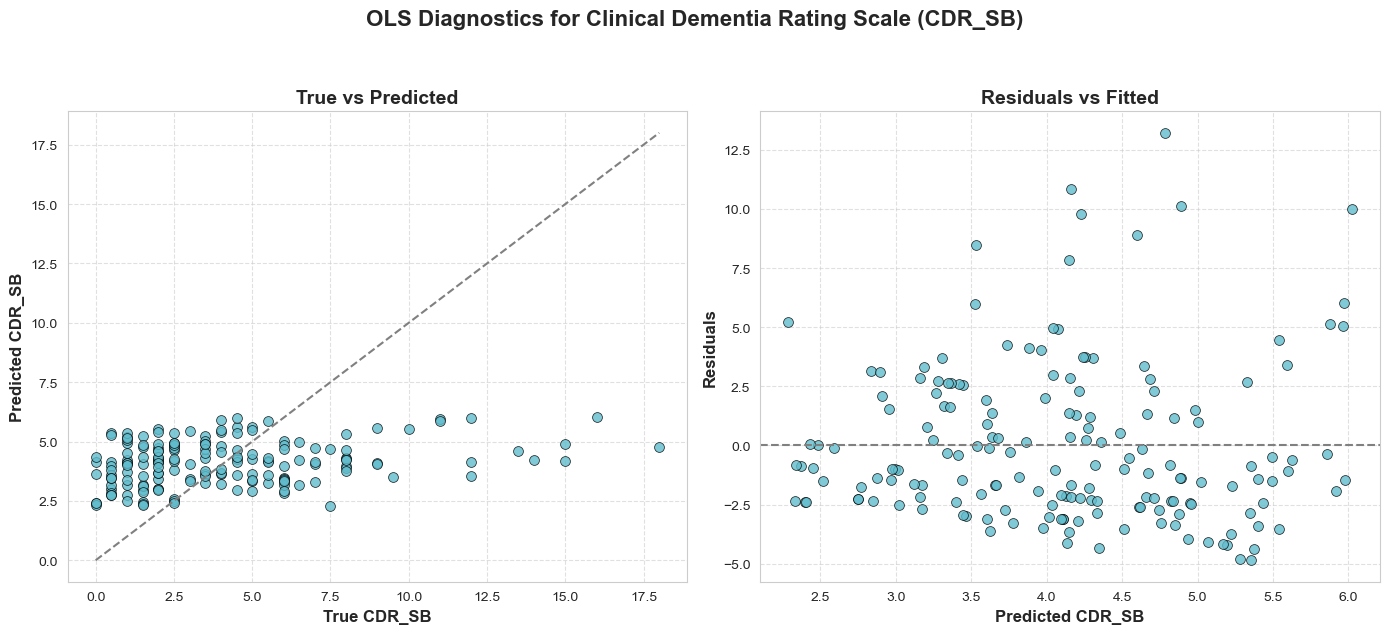

In [76]:
plot_ols_diagnostics(y, y_pred, residuals, "OLS Diagnostics for Clinical Dementia Rating Scale (CDR_SB)")

#### Analysis

In [78]:
print("MAE e RMSE", round(mean_absolute_error(y, y_pred),4), round(np.sqrt(mean_squared_error(y, y_pred)),4))

MAE e RMSE 2.6105 3.3478


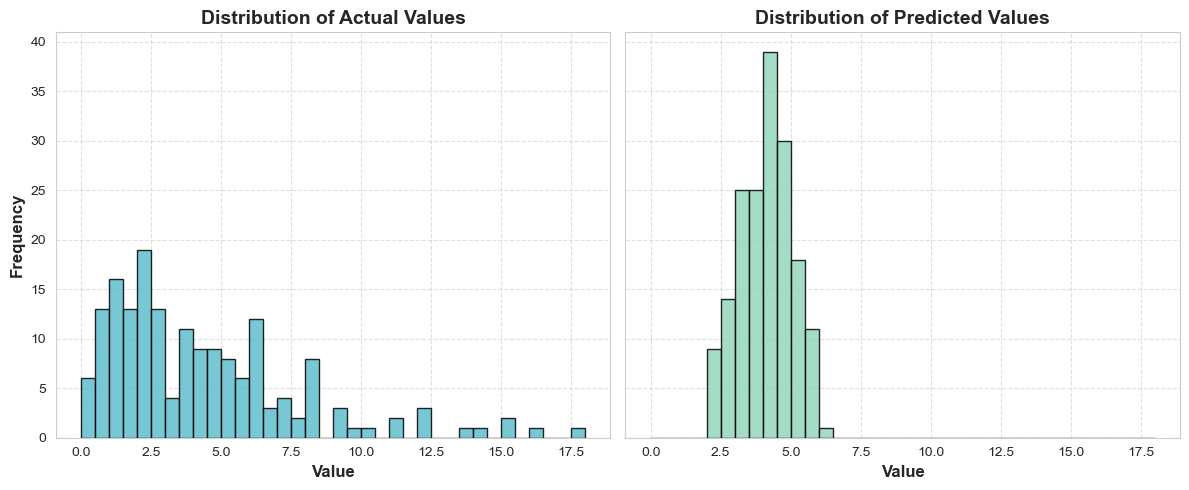

In [79]:
actual = y
pred = y_pred

# Binning
bins = np.arange(min(actual), max(actual) + 0.5, 0.5)

# Subplot
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axs[0].hist(actual, bins=bins, color='#61bdcd', edgecolor='black', alpha=0.85)
axs[0].set_title('Distribution of Actual Values', fontsize=14, weight='bold')
axs[0].set_xlabel('Value', fontsize=12, weight='bold')
axs[0].set_ylabel('Frequency', fontsize=12, weight='bold')
axs[0].grid(True, linestyle='--', alpha=0.6)

axs[1].hist(pred, bins=bins, color='#95d6bb', edgecolor='black', alpha=0.85)
axs[1].set_title('Distribution of Predicted Values', fontsize=14, weight='bold')
axs[1].set_xlabel('Value', fontsize=12, weight='bold')
axs[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [80]:
# Compute RMSE per subject
rmse_subject = np.sqrt(residuals ** 2)

# Create a new dataframe with per-subject error
subject_errors = df_merged[['ID', 'Group', 'CDR_SB']].copy()
subject_errors['Predicted CDR_SB'] = y_pred
subject_errors['RMSE'] = rmse_subject

# Group-level RMSE stats
group_rmse_stats = subject_errors.groupby('Group')['RMSE'].agg(
    Mean_RMSE='mean',
    Std_RMSE='std',
    N='count'
).round(2).sort_values('Mean_RMSE', ascending=False)

print("RMSE by diagnostic group:")
print(group_rmse_stats)


RMSE by diagnostic group:
       Mean_RMSE  Std_RMSE   N
Group                         
PSP       2.9400    2.3000  58
CBS       2.9000    2.2100  42
ADNI      2.1700    1.7900  72


In [81]:
# Sort subjects by RMSE
subject_errors_sorted = subject_errors.sort_values(by='RMSE').reset_index(drop=True)

print("\nSubjects ranked by RMSE (best to worst):")
print(subject_errors_sorted.to_string(index=False))


Subjects ranked by RMSE (best to worst):
        ID Group  CDR_SB  Predicted CDR_SB    RMSE
027_S_5277  ADNI  2.5000            2.4836  0.0164
  1_S_5089   CBS  3.5000            3.5361  0.0361
027_S_6788  ADNI  2.5000            2.4283  0.0717
007_S_6341  ADNI  2.5000            2.5933  0.0933
127_S_6549  ADNI  3.5000            3.6156  0.1156
  1_S_5017   CBS  4.5000            4.6341  0.1341
  1_S_5048   CBS  4.0000            3.8605  0.1395
  1_S_5083   CBS  4.5000            4.3585  0.1415
027_S_6965  ADNI  4.5000            4.2610  0.2390
  1_S_5055   PSP  3.5000            3.2478  0.2522
  5_S_5008   PSP  3.5000            3.7582  0.2582
  1_S_5045   PSP  4.0000            3.6795  0.3205
  1_S_5010   PSP  3.0000            3.3366  0.3366
168_S_6142  ADNI  4.5000            4.1572  0.3428
  1_S_5039   CBS  5.5000            5.8593  0.3593
036_S_4538  ADNI  4.0000            3.6395  0.3605
019_S_6668  ADNI  3.0000            3.4114  0.4114
  1_S_5000   CBS  5.0000            5.49

# CNN

## Data

### Loading

In [62]:
# Set paths
file_name = "1_S_5005.FDC.nii.gz"

# Load raw image
path_temp = os.path.join(dir_FCmaps, file_name)
img = nib.load(path_temp)
data_raw = img.get_fdata()
affine = img.affine

### Pre-processing

In [63]:
# Load GM mask
mask = nib.load(gm_mask_path).get_fdata()
mask = mask != 0

# Parameters
threshold = 0.1
apply_normalization = True

# Threshold
data_proc = np.copy(data_raw)
data_proc[data_proc < threshold] = 0

# Masking
data_proc[~mask] = 0

# Normalization
if apply_normalization:
    nonzero = data_proc[data_proc != 0]
    if nonzero.size > 0:
        min_val = nonzero.min()
        max_val = nonzero.max()
        if max_val != min_val:
            data_proc[data_proc != 0] = (data_proc[data_proc != 0] - min_val) / (max_val - min_val)

In [64]:
# Output path
out_dir = "/Users/emmatosato/Documents/PhD/ANM_Verona"
base_name = file_name.replace('.nii.gz', '')

raw_save_path = os.path.join(out_dir, f"{base_name}.raw.nii.gz")
nii_save_path = os.path.join(out_dir, f"{base_name}.processed01.nii.gz")

# Save as .nii.gz
raw_img = nib.Nifti1Image(data_raw, affine)
nib.save(raw_img, raw_save_path)

proc_img = nib.Nifti1Image(data_proc, affine)
nib.save(proc_img, nii_save_path)

## Analysis

Example of comparison between the raw and processed images

In [75]:
# --- Paths ---
raw_map_path = '/Users/emmatosato/Documents/PhD/ANM_Verona/1_S_5005.FDC.raw.nii.gz'
processed_map_path = '/Users/emmatosato/Documents/PhD/ANM_Verona/1_S_5005.FDC.processed02.nii.gz'

# --- Load the NIfTI files ---
raw_img = nib.load(raw_map_path).get_fdata()
processed_img = nib.load(processed_map_path).get_fdata()

# --- Flatten the images ---
raw_flat = raw_img.flatten()
processed_flat = processed_img.flatten()

In [82]:
# --- Compare voxels ---
# 1. Absolute difference
abs_diff = np.abs(raw_flat - processed_flat)

# 2. Mean absolute difference
mean_abs_diff = abs_diff.mean()

# 3. Percentage of voxels that changed
changed_voxels = abs_diff > 1e-6  # Mask of changed voxels
num_changed_voxels = np.sum(changed_voxels)
total_voxels = raw_flat.shape[0]
percentage_changed = (num_changed_voxels / total_voxels) * 100

# 4. Among changed voxels, percentage that became zero
changed_and_now_zero = (processed_flat[changed_voxels] == 0)
percentage_changed_to_zero = (np.sum(changed_and_now_zero) / num_changed_voxels) * 100

In [83]:
# --- Print results ---
print(f"Mean absolute difference: {mean_abs_diff:.6f}")
print(f"Percentage of voxels changed: {percentage_changed:.2f}%")
print(f"Percentage of changed voxels that became zero: {percentage_changed_to_zero:.2f}%")

Mean absolute difference: 0.018292
Percentage of voxels changed: 34.25%
Percentage of changed voxels that became zero: 97.50%


In [84]:
# Find indices of changed voxels
changed_indices = np.where(abs_diff > 1e-6)[0]

# Among changed, select only those that stayed nonzero
stayed_nonzero_indices = changed_indices[processed_flat[changed_indices] != 0]

# Show first examples
num_examples = 10

print("Examples of changed voxels that stayed NONZERO:")
for idx in stayed_nonzero_indices[:num_examples]:
    print(f"Voxel {idx}: {raw_flat[idx]:.6f} → {processed_flat[idx]:.6f}")

Examples of changed voxels that stayed NONZERO:
Voxel 113695: 0.201731 → 0.005446
Voxel 113786: 0.200262 → 0.000803
Voxel 113876: 0.203708 → 0.011693
Voxel 113967: 0.216750 → 0.052908
Voxel 114057: 0.201688 → 0.005309
Voxel 114058: 0.214249 → 0.045004
Voxel 114148: 0.206350 → 0.020042
Voxel 114346: 0.202298 → 0.007239
Voxel 114436: 0.210085 → 0.031846
Voxel 114437: 0.219474 → 0.061515
